# Heuristic Search 

In [1]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt

from map_utils import *
from search import *
from graphics_utils import *

In [2]:
def solve_and_plt(env: gym.Env, heuristic: callable, precision: str, plt_width: Tuple[int, int], plt_height: Tuple[int, int], dynamic: bool = False):
    state = env.reset()
    game_map = state["chars"]
    color_map = state["colors"]
    pixel_map = state["pixel"]

    start = get_player_location(game_map)
    target = get_target_location(game_map)

    if dynamic:
        dynamic_path_finding(game_map, color_map, start, target, env, heuristic, graphics=True, pixel_map=pixel_map)
    else:
        path = a_star(game_map, color_map, start, target, heuristic, precision=precision)
        actions = actions_from_path(start, path[1:])
        render_actions(actions, env, pixel_map, plt_width, plt_height)

## 1. The Fully Observable Environment

The idea was to approach the problem in an increasing level of difficolty fashion, first working on some simpler heuristics and cost functions, up to reaching a more sofisticated level of complexity. 

We started by comparing the Euclidean Distance and the Chebyshev Distance, in order to get a better grasp on what the problem could have been approached with, and after a short analysis, we've found out that the Chebyshev looked exactly like what we were searching for, since it guaranteed 8 normal vectors that precisely represented what the actions of the agent are supposed to be.

The agent successfully completed the task!


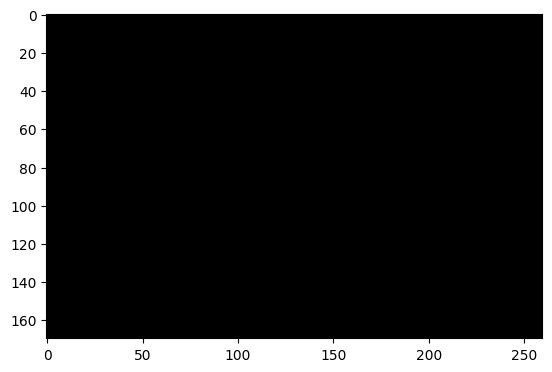

In [12]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=("chars", "pixel", "colors"), des_file = "dat/simple_maze.des")
solve_and_plt(env, heuristic=euclidean_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The agent successfully completed the task!


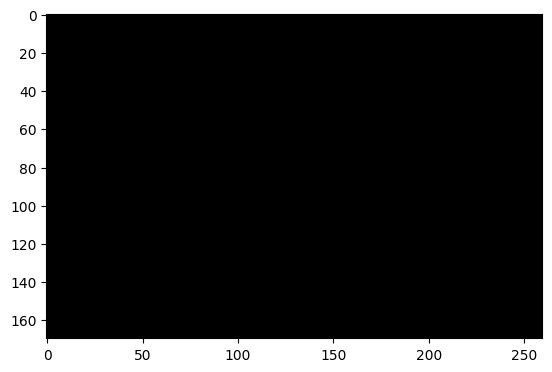

In [13]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=("chars", "pixel", "colors"), des_file = "dat/simple_maze.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

Initially, a simpler version of the problem was tackled. An A* algorithm was implemented that could find the optimal path in a map with trees.

The agent successfully completed the task!


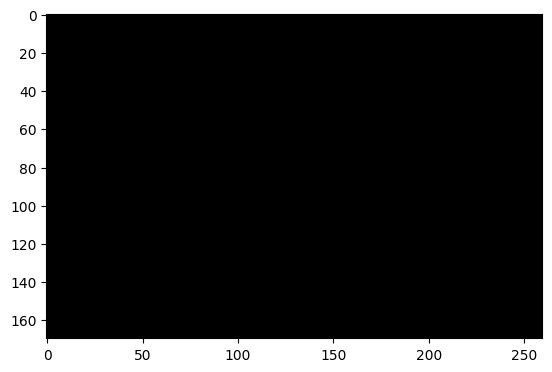

In [17]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/square_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The algorithm also works on more intricate map configurations, that are not constrained to a square shape.

The agent successfully completed the task!


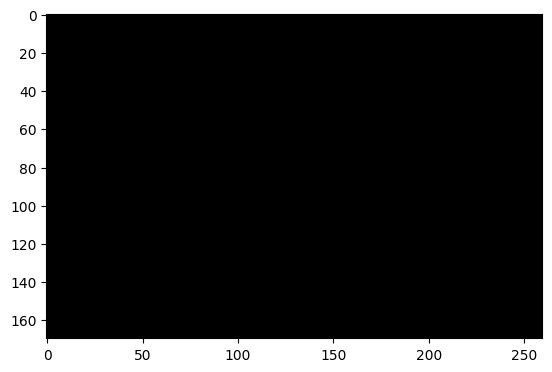

In [18]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/maze_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The problem was made more complex with the introduction of clouds and a "grid bug," a relatively weak monster in Nethack. This creature, matching the player's speed, is unable to ever catch up with the agent, adding a strategic element to the scenario. 

To effectively face this issue, a dynamic A* algorithm was implemented. This  solution recalculates the path based on whether the monster is visible or not. In scenarios where the monster is visible, the agent incurs no penalties traversing through clouded areas. Instead, in instances where the monster remains hidden, traversing through clouded regions carries a risk, as these areas could be secret hiding places for the lurking monster.


The agent successfully completed the task!


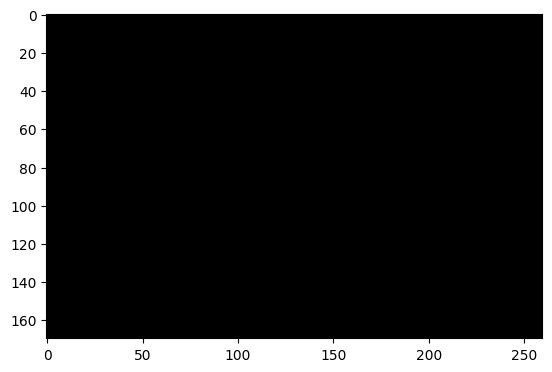

In [20]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/grid_bug.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The final stage of the fully observable problem involved addressing the comprehensive challenge at hand. A diverse array of monsters was integrated into the scenario. 

At first, we just applied the strategy used so far to get to the target, but we soon found out that we may have needed some more sofistication.

The agent died.


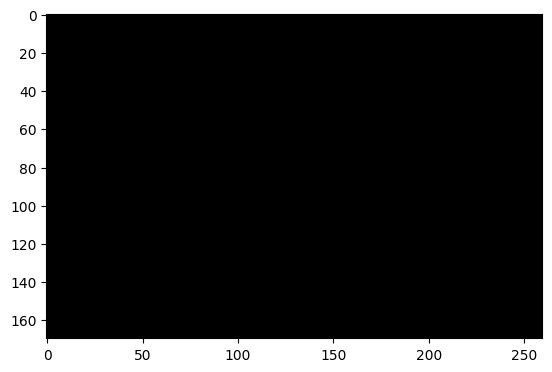

In [35]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The idea behind the improved strategy roots in two simple concepts:
- when the agent has the chance to see the monster in the map, it should keep itself further from it
- when the agent does not have a chance to get to know where the monster may be hiding itself the agent must stay further from clouds as much as it might, for this very reason

The agent successfully completed the task!


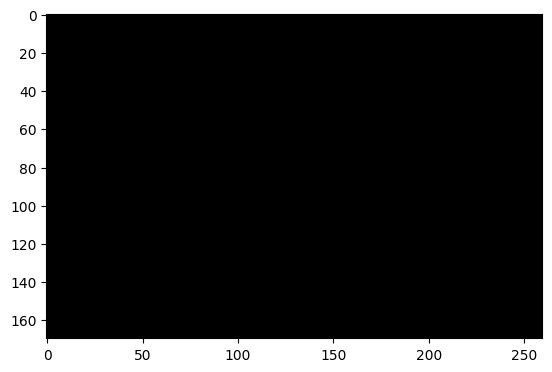

In [3]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

let us give a brief discussion on the reasons behind the procedure working:
$$d(P, Q) = \max_{i=1}^{n} |p_i - q_i|$$

In [4]:
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-HideNSeek-Mapped-v0", dynamic_path_finding, evaluation_steps=500)

print(f"wins: {win}")
print(f"beaten monsters: {monsters_win}")
print(f"losses: {loss}")
print(f"monster that got us beaten: {monsters_loss}")

wins: 362
beaten monsters: [None, None, None, 'N', 'H', 'L', 'T', 'D', 'L', 'N', 'T', None, 'L', 'D', 'H', 'H', 'O', 'N', 'O', 'O', 'T', 'O', 'T', 'O', 'O', 'L', 'N', 'N', 'O', None, None, 'O', None, 'L', 'N', None, 'L', 'H', None, 'N', 'N', 'O', 'L', None, None, None, 'L', None, 'L', None, 'O', None, 'T', 'N', None, 'T', 'O', 'O', 'H', 'T', None, 'H', 'H', 'N', 'H', 'H', 'N', None, 'T', None, None, 'H', 'H', None, 'N', None, 'D', None, 'O', 'T', 'D', 'L', 'H', 'O', 'L', 'L', 'L', 'O', 'L', None, None, 'D', None, 'H', None, None, 'N', 'N', 'T', None, 'L', None, 'H', 'D', 'O', 'H', None, 'L', 'O', 'T', 'N', 'H', None, 'T', 'L', 'L', 'O', None, 'L', 'D', 'L', 'O', 'L', 'L', 'T', 'H', None, 'H', None, 'N', 'D', None, 'H', 'H', 'N', 'D', 'O', None, 'H', 'T', 'D', None, None, 'T', 'L', 'H', 'O', 'L', 'H', 'L', 'T', 'T', None, 'N', 'D', 'N', 'T', None, 'N', 'D', 'O', 'L', None, 'N', 'O', None, 'L', 'N', 'N', 'T', 'N', 'T', 'H', None, 'L', 'H', 'T', None, None, 'T', None, None, 'D', None, 'O'

In [16]:
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_c.des", evaluation_steps=500)

print(f"wins: {win}")
print(f"beaten monsters: {monsters_win}")
print(f"losses: {loss}")
print(f"monster that got us beaten: {monsters_loss}")

wins: 460
beaten monsters: ['H', 'H', None, 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', None, 'H', 'H', 'H', 'H', 'H', None, 'H', None, None, None, 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', None, 'H', 'H', 'H', 'H', None, None, None, 'H', None, None, None, 'H', 'H', 'H', None, 'H', None, 'H', None, 'H', 'H', None, None, 'H', 'H', None, 'H', None, 'H', 'H', None, 'H', 'H', 'H', 'H', 'H', None, 'H', 'H', None, 'H', None, 'H', None, 'H', 'H', None, 'H', 'H', None, 'H', 'H', None, None, None, None, 'H', None, 'H', 'H', 'H', 'H', None, 'H', None, 'H', 'H', 'H', None, None, 'H', 'H', 'H', None, 'H', 'H', 'H', None, 'H', 'H', 'H', 'H', 'H', 'H', None, 'H', None, None, 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', None, 'H', 'H', 'H', 'H', None, 'H', 'H', 'H', None, 'H', None, 'H', 'H', 'H', 'H', 'H', None, 'H', 'H', 'H', 'H', None, 'H', 'H', None, 'H', 'H', 'H', None, None, 'H', None, 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', None, 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 

In [17]:
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des="dat/fully_observable_c.des", evaluation_steps=500)

print(f"wins: {win}")
print(f"beaten monsters: {monsters_win}")
print(f"losses: {loss}")
print(f"monster that got us beaten: {monsters_loss}")

wins: 292
beaten monsters: ['N', 'N', 'N', None, None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', None, 'N', 'N', 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 'N', 'N', None, 'N', 'N', 'N', 

In [13]:
ml = [x for x in monsters_loss if x != None]
np.unique(ml, return_counts=True)

In [28]:
from minihack import LevelGenerator

# Define the maze as a string
maze = """
...........
...........
...........
...........
...........
...........
...........
...........
...........
"""
# Set a start and goal positions
lvl_gen = LevelGenerator(map=maze,flags=('hardfloor','premapped'))
lvl_gen.set_start_pos((0,0))
lvl_gen.add_goal_pos((10,8))
# Add a Minotaur at fixed position
lvl_gen.add_monster(name="giant", place=(5,4))
lvl_gen.add_terrain((6,4),'C')
lvl_gen.add_terrain((1,0),'C')
lvl_gen.add_terrain((2,0),'T')
lvl_gen.add_terrain((4,0),'T')
lvl_gen.add_terrain((5,0),'T')
lvl_gen.add_terrain((7,0),'T')
lvl_gen.add_terrain((4,1),'C')
lvl_gen.add_terrain((6,1),'C')
lvl_gen.add_terrain((8,1),'C')
lvl_gen.add_terrain((0,2),'T')
lvl_gen.add_terrain((10,2),'C')
lvl_gen.add_terrain((0,3),'T')
lvl_gen.add_terrain((10,3),'C')
lvl_gen.add_terrain((1,3),'C')
lvl_gen.add_terrain((0,4),'T')
lvl_gen.add_terrain((8,4),'C')
lvl_gen.add_terrain((9,4),'C')
lvl_gen.add_terrain((1,4),'C')
lvl_gen.add_terrain((0,5),'C')
lvl_gen.add_terrain((1,5),'C')
lvl_gen.add_terrain((4,5),'C')
lvl_gen.add_terrain((9,5),'C')
lvl_gen.add_terrain((1,6),'T')
lvl_gen.add_terrain((5,6),'T')
lvl_gen.add_terrain((6,6),'C')
lvl_gen.add_terrain((10,6),'C')   
lvl_gen.add_terrain((4,7),'C')
lvl_gen.add_terrain((5,7),'C')
lvl_gen.add_terrain((6,7),'C')
lvl_gen.add_terrain((8,7),'C')   
lvl_gen.add_terrain((9,7),'T')    
lvl_gen.add_terrain((4,8),'T')
lvl_gen.add_terrain((1,8),'C')
lvl_gen.add_terrain((6,8),'C')
lvl_gen.add_terrain((7,8),'T')   
lvl_gen.add_terrain((8,8),'T')

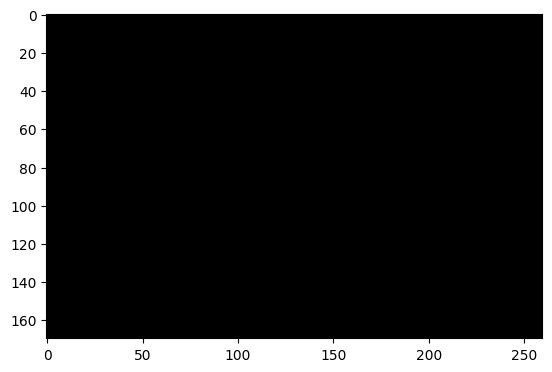

In [31]:
env = gym.make("MiniHack-Navigation-Custom-v0",des_file= lvl_gen.get_des(), observation_keys=('chars','colors','pixel'))
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)